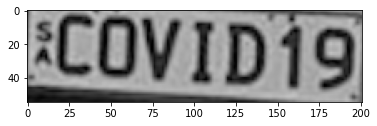

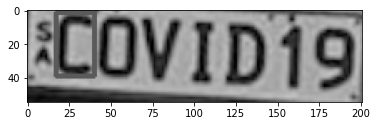

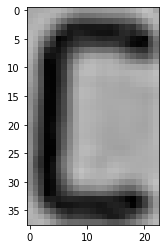

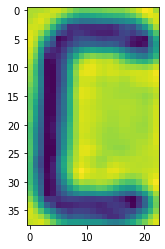

(50, 50, 3)


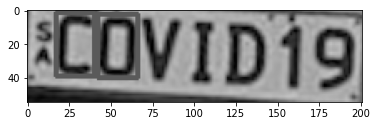

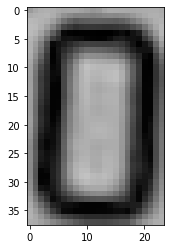

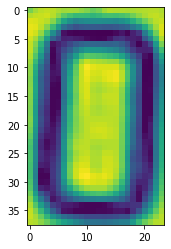

(50, 50, 3)


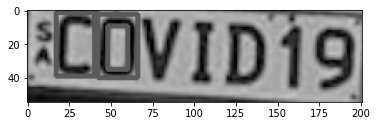

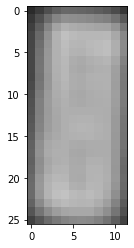

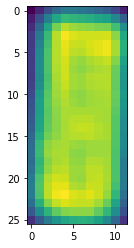

(50, 50, 3)


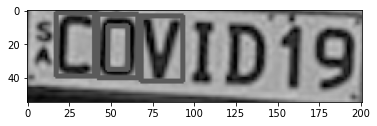

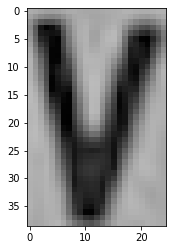

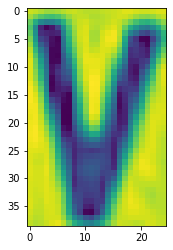

(50, 50, 3)


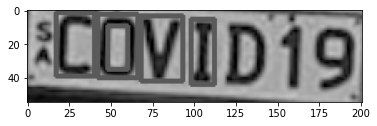

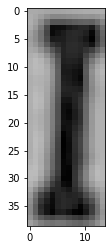

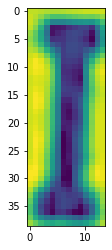

(50, 50, 3)


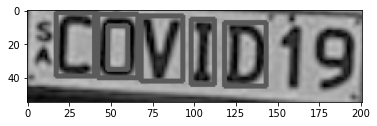

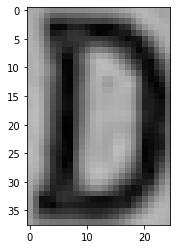

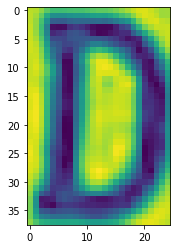

(50, 50, 3)


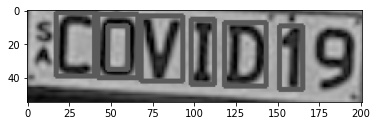

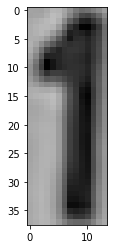

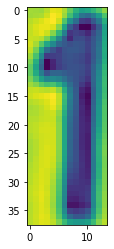

(50, 50, 3)


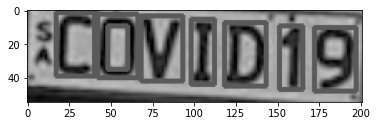

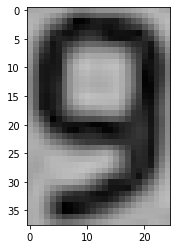

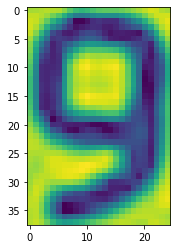

(50, 50, 3)
TRAINED MODEL GUESS: C0IVID19


In [18]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
from keras.models import load_model
from tensorflow.keras.optimizers import Adam 


# LOAD AND COMPILE MODEL 
model = load_model('model_char_rec.h5')
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


img1 = cv2.imread('media/bmw.jpg')
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
b_filter = cv2.bilateralFilter(img1_gray, 11, 17, 17)  # noise removal
edges = cv2.Canny(b_filter, 30, 200)  # locates edges using Canny algorithm
contours = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# ^ arguments: 1. source image, 2. contour retrieval mode, 3. contour approx. method

contours = imutils.grab_contours(contours)
# contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:  # if the approximated polygon has four vertices,
        location = approx  # save its vertices' coordinates
        break

# PRINT RECTANGLE AROUND LICENSE PLATE
detect_rect = cv2.rectangle(img1, tuple(location[0][0]), tuple(location[2][0]), (0, 255, 0), 4)
# ^ arguments: 1. source image, 2. top left coordinate, 3. bottom right coordinate, 4. RGB, 5. thickness
# ^^ creates a new image where rectangle is imposed on top of original car image
## plt.imshow(cv2.cvtColor(detect_rect, cv2.COLOR_BGR2RGB))  # convert to RGB before plt.show()
plt.show()  # display imposed rectangle
# PRINT CROPPED LICENSE PLATE
(x1, y1) = tuple(location[0][0])
(x2, y2) = tuple(location[2][0])
cropped = img1_gray[y1:y2+1, x1:x2+1]
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.show()  # display cropped license plate

cropped2 = cropped.copy()

def predict(img):
    dictionary = {0:'0', 1:'1', 2 :'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A',
    11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K',
    21:'L', 22:'M', 23:'N', 24:'P', 25:'Q', 26:'R', 27:'S', 28:'T', 29:'U',
    30:'V', 31:'W', 32:'X', 33:'Y', 34:'Z'}
    
    plt.imshow(img)
    plt.show()
    blackAndWhiteChar = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    blackAndWhiteChar = cv2.resize(blackAndWhiteChar,(50,50))
    print(blackAndWhiteChar.shape)
    blackAndWhiteChar = blackAndWhiteChar[:,:,0]
    image = blackAndWhiteChar.reshape((1, 50,50, 1))
    image = image / 255.0
    new_predictions = model.predict(image)
    char = np.argmax(new_predictions)
    return dictionary[char]

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged


# CHARACTER SEGMENTATION
thresh_inv = cv2.adaptiveThreshold(cropped,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,39,1)
edges2 = auto_canny(thresh_inv)
ctrs, _ = cv2.findContours(edges2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
img_area = cropped.shape[0]*cropped.shape[1]

final_str = ''
for i, ctr in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(ctr)
    roi_area = w*h
    roi_ratio = roi_area/img_area
    if((roi_ratio >= 0.015) and (roi_ratio < 0.09)):
        if ( (h > 1.2*w) and (h <= 3*w) ):
            curr_rect = cv2.rectangle(cropped,(x,y),( x + w, y + h ),(90,0,255),2)
            # cv2.cvtColor(curr_rect, cv2.COLOR_BGR2GRAY)
            plt.imshow(cv2.cvtColor(curr_rect, cv2.COLOR_BGR2RGB))
            plt.show()
            single_letter = cropped2[y:y+h, x:x+w]
            plt.imshow(cv2.cvtColor(single_letter, cv2.COLOR_BGR2RGB))
            plt.show()
            final_str += predict(single_letter)

print('TRAINED MODEL GUESS: {}'.format(final_str))
